In [1]:
import sys
#sys.path.append('..')
from QAOA import QAOArunner
from MaxCutProblem import MaxCutProblem
import params
from rustworkx.visualization import mpl_draw as draw_graph
from old_jupyter_vizualisers.load_data import load_graph_from_csv

In [2]:
import itertools

settings = {
'backend_mode' : ['noisy_sampling'],
'qaoa_variant': ['vanilla'],
'param_initialization': ['gaussian','static'],
'depth':[10],#MANGLER 10 PÅ MULTIANGLE
'warm_start': [False,True]
}

keys = settings.keys()
values = settings.values()

combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(f'echo "{combinations}" > test_settings.txt')
#print(len(combinations))

echo "[{'backend_mode': 'noisy_sampling', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 10, 'warm_start': False}, {'backend_mode': 'noisy_sampling', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 10, 'warm_start': True}, {'backend_mode': 'noisy_sampling', 'qaoa_variant': 'vanilla', 'param_initialization': 'static', 'depth': 10, 'warm_start': False}, {'backend_mode': 'noisy_sampling', 'qaoa_variant': 'vanilla', 'param_initialization': 'static', 'depth': 10, 'warm_start': True}]" > test_settings.txt


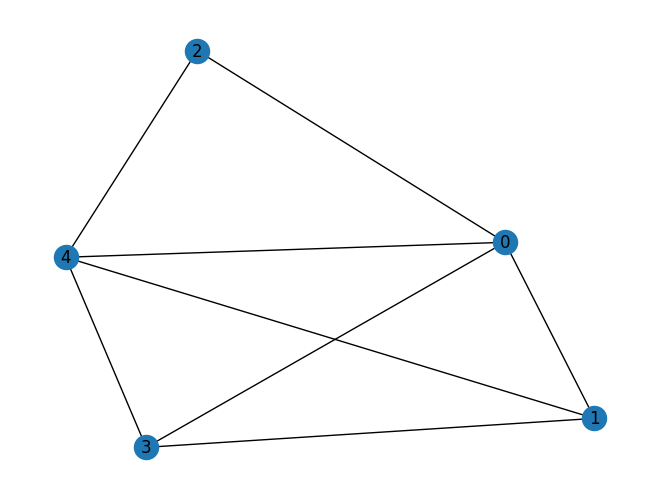

In [3]:
from MaxCutProblem import MaxCutProblem
problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs([5,7,9])

graph = graphs[1]
#graph = problem.get_graph_by_name(name)
#graph = load_graph_from_csv('data/11_nodes_links_scand.csv')
#draw_graph(graph, with_labels=True)

draw_graph(graph, with_labels=True)

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IZIZI', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[0.25 +0.j, 0.5  +0.j, 0.125+0.j, 0.25 +0.j, 0.125+0.j, 0.375+0.j,
 0.125+0.j, 0.5  +0.j])


c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\torbjsm

Total time: 11.739514827728271 in which 0.00% was spent inside the cost_func_estimator and 1.00 inside optimizer and help functions.
[0, 0, 0, 0, 0]
0.0
63
[3.30308653 1.31437363]
m 0.0178


c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


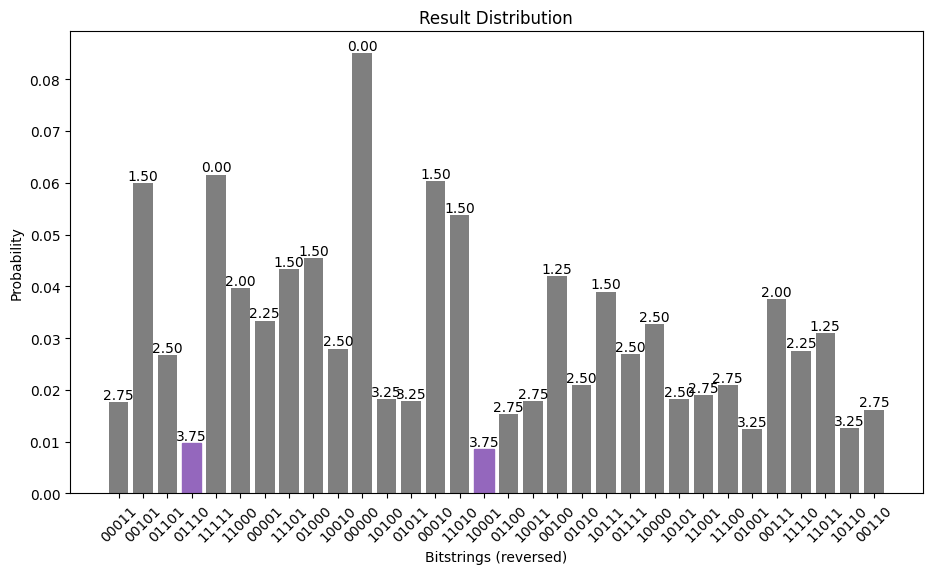

In [10]:
import numpy as np
quantum = QAOArunner(graph=graph, 
                     backend_mode = 'noisy_sampling',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='L-BFGS-B',
                     warm_start=False,
                     depth = 1,
                     vertexcover=False,
                     amount_shots = 5000,
                     max_tol = 1e-8#lower shots and tolerance for faster runs
                     )

quantum.build_circuit()
print(quantum.cost_hamiltonian)
quantum.run()
print(f'Total time: {quantum.time_elapsed} in which {np.sum(quantum.runtimes)/quantum.time_elapsed:.2f}% was spent inside the cost_func_estimator and {1 - np.sum(quantum.runtimes)/quantum.time_elapsed:.2f} inside optimizer and help functions.')
print(quantum.solution)
print(quantum.evaluate_solution())
print(quantum.fev)
print(quantum.final_params)
print('m',quantum.get_prob_measure_optimal())
quantum.print_bitstrings()

<Figure size 640x480 with 0 Axes>

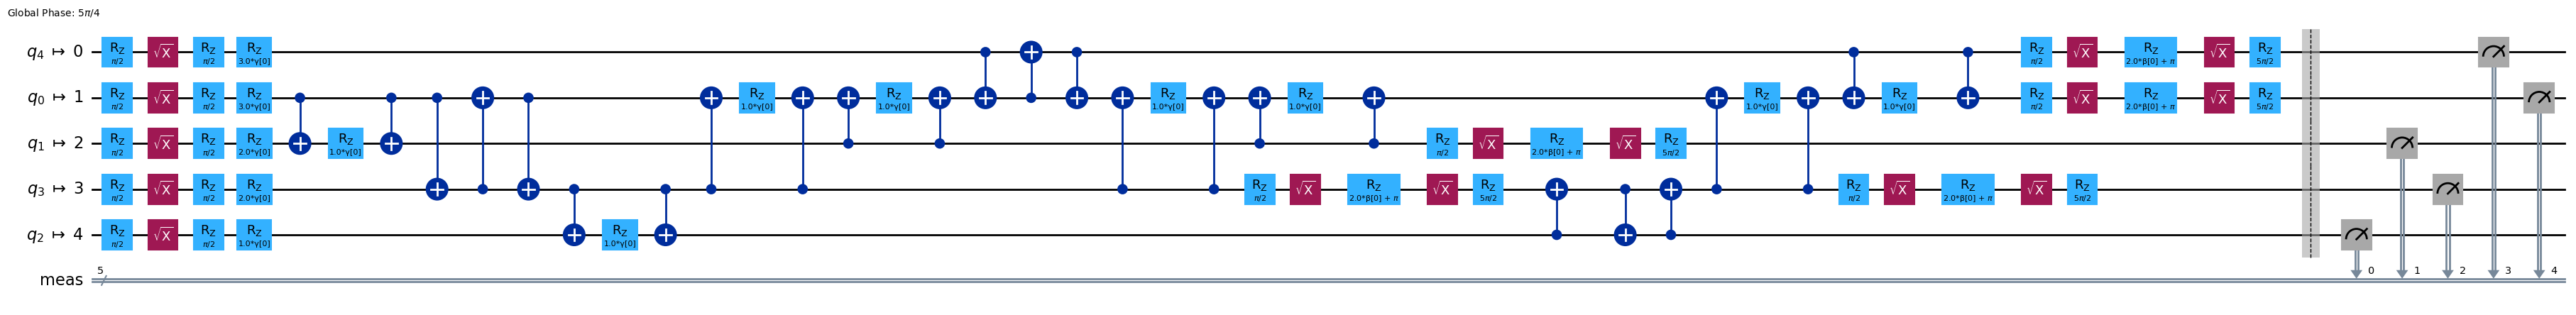

In [5]:
quantum.draw_circuit()


In [6]:
job = quantum.get_job_custom_circuit(quantum.circuit)
print((job.result()[0].data))
print(quantum.final_params)

DataBin(meas=BitArray(<shape=(), num_shots=5000, num_bits=5>))
[3.08241251 1.52599152]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_ibm_runtime import EstimatorV2 as Estimator
# Define the grid resolution
num_points = 50
gamma_vals = np.linspace(0, 2* np.pi, num_points)
beta_vals = np.linspace(0,1* np.pi, num_points)
Gamma, Beta = np.meshgrid(gamma_vals, beta_vals)
Z = np.zeros_like(Gamma)

graph = problem.get_paper_graphs()[0]

minvertexcover = True

quantum = QAOArunner(graph=graph, 
                     backend_mode='statevector',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 1,
                     vertexcover=minvertexcover,
                     amount_shots = 1000,
                     max_tol = 1e-8,
                     lagrangian_multiplier=2
                     )
quantum.build_circuit()
estimator = Estimator(mode=quantum.backend)
estimator.options.default_shots = 5000
# Evaluate cost function at each grid point



for i in tqdm(range(Gamma.shape[0]), desc="Evaluating energy landscape"):
    for j in range(Gamma.shape[1]):
        params = np.array([Gamma[i, j], Beta[i, j]])  # Format your params as needed
        Z[i, j] = quantum.get_prob_measure_optimal(params, quantum.circuit, quantum.cost_hamiltonian,estimator)

# Plot the energy landscape
plt.figure(figsize=(8, 6))
cp = plt.contourf(Gamma, Beta, Z, levels=50)
plt.colorbar(cp, label='Energy')
plt.title("Energy Landscape over [γ, β]")
plt.xlabel("Gamma (γ)")
plt.ylabel("Beta (β)")
plt.show()


Evaluating energy landscape:   0%|          | 0/50 [00:00<?, ?it/s]


TypeError: QAOArunner.get_prob_measure_optimal() takes 1 positional argument but 5 were given

In [ ]:
import pandas as pd

# Save Z as a CSV file
df_z = pd.DataFrame({'x': Gamma.ravel(), 'y': Beta.ravel(), 'z': Z.ravel()})
df_z.columns = ['x', 'y', 'z']
df_z.to_csv('percentage_measure_optimal_erdos_renyi_5_2_MaxCut.csv', index=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

strin = 'MinVertexCover' if minvertexcover else 'MaxCut'

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=Gamma, y=Beta, colorscale='Viridis')])
fig.update_layout(
    title=f"Percent chance of sampling optimal solution given [γ, β] for Erdos Renyi graph size 5, high prob of edges, for {strin}",
    scene=dict(
        xaxis_title="Gamma (γ)",
        yaxis_title="Beta (β)",
        zaxis_title="Energy"
    )
)
fig.show()

